In [9]:
!pip install catboost chart_studio cufflinks xgboost;

Defaulting to user installation because normal site-packages is not writeable
  Using cached xgboost-1.6.1-py3-none-win_amd64.whl (125.4 MB)


In [10]:
#data libs
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import tqdm
import warnings

#models
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import cross_val_score

from sklearn.neighbors import KNeighborsClassifier

from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

from sklearn.svm import SVC, SVR

from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

import xgboost as xgb

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.pipeline import make_union, make_pipeline

from catboost import CatBoostClassifier

#scalers
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

#metrics
from sklearn.metrics import auc, roc_auc_score, mean_squared_error, roc_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [11]:
#check missing data
def check_missing(data,output_path=None):    
    result = pd.concat([data.isnull().sum(),data.isnull().mean()],axis=1)
    result = result.rename(index=str,columns={0:'total missing',1:'proportion'}).sort_values(by='total missing', ascending=False)
    if output_path is not None:
        result.to_csv(output_path+'missing.csv')
        print(output_path, 'missing.csv')
    return result[result['total missing']!=0]


#fill NaNs with mean, median or mode
def impute_NA_with_avg(data,strategy='mean',NA_col=[]):
    data_copy = data.copy(deep=True)
    for i in NA_col:
        if data_copy[i].isnull().sum()>0:
            if strategy=='mean':
                data_copy[i+'_impute_mean'] = data_copy[i].fillna(data[i].mean())
            elif strategy=='median':
                data_copy[i+'_impute_median'] = data_copy[i].fillna(data[i].median())
            elif strategy=='mode':
                data_copy[i+'_impute_mode'] = data_copy[i].fillna(data[i].mode()[0])
        else:
            warnings.warn("Нет пропущенных значений" % i)
    return data_copy  

#fill NaNs with the tail of distibution
def impute_NA_with_end_of_distribution(data,NA_col=[]):
    data_copy = data.copy(deep=True)
    for i in NA_col:
        if data_copy[i].isnull().sum()>0:
            data_copy[i+'_impute_end_of_distri'] = data_copy[i].fillna(data[i].mean()+3*data[i].std())
        else:
            warnings.warn("Нет пропущенных значений" % i)
    return data_copy 

#outlier detection by interquantile
def outlier_detect_IQR(data,col,threshold=3):    
    IQR = data[col].quantile(0.75) - data[col].quantile(0.25)
    Lower_fence = data[col].quantile(0.25) - (IQR * threshold)
    Upper_fence = data[col].quantile(0.75) + (IQR * threshold)
    para = (Upper_fence, Lower_fence)
    tmp = pd.concat([data[col]>Upper_fence,data[col]<Lower_fence],axis=1)
    outlier_index = tmp.any(axis=1)
    print('Количество выбросов в данных:',outlier_index.value_counts()[1])
    print('Доля выбросов:',outlier_index.value_counts()[1]/len(outlier_index))
    return outlier_index, para

#outlier detection by mean
def outlier_detect_mean_std(data,col,threshold=3):
    Upper_fence = data[col].mean() + threshold * data[col].std()
    Lower_fence = data[col].mean() - threshold * data[col].std()   
    para = (Upper_fence, Lower_fence)   
    tmp = pd.concat([data[col]>Upper_fence,data[col]<Lower_fence],axis=1)
    outlier_index = tmp.any(axis=1)
    print('Количество выбросов в данных:',outlier_index.value_counts()[1])
    print('Доля выбросов:',outlier_index.value_counts()[1]/len(outlier_index))
    return outlier_index, para

#replace outliers with end of q
def windsorization(data,col,para,strategy='both'):
    data_copy = data.copy(deep=True)  
    if strategy == 'both':
        data_copy.loc[data_copy[col]>para[0],col] = para[0]
        data_copy.loc[data_copy[col]<para[1],col] = para[1]
    elif strategy == 'top':
        data_copy.loc[data_copy[col]>para[0],col] = para[0]
    elif strategy == 'bottom':
        data_copy.loc[data_copy[col]<para[1],col] = para[1]  
    return data_copy

#outlier drop
def drop_outlier(data, outlier_index):
    data_copy = data[~outlier_index]
    return data_copy

#fill outliers with mean, median or mode
def impute_outlier_with_avg(data,col,outlier_index,strategy='mean'):
    data_copy = data.copy(deep=True)
    if strategy=='mean':
        data_copy.loc[outlier_index,col] = data_copy[col].mean()
    elif strategy=='median':
        data_copy.loc[outlier_index,col] = data_copy[col].median()
    elif strategy=='mode':
        data_copy.loc[outlier_index,col] = data_copy[col].mode()[0]           
    return data_copy


def constant_feature_detect(data,threshold=0.98):    
    data_copy = data.copy(deep=True)
    quasi_constant_feature = []
    for feature in data_copy.columns:
        predominant = (data_copy[feature].value_counts() / np.float(
                      len(data_copy))).sort_values(ascending=False).values[0]
        if predominant >= threshold:
            quasi_constant_feature.append(feature)
    print(len(quasi_constant_feature),'константные переменные')    
    return quasi_constant_feature

def corr_feature_detect(data,threshold=0.8):
    
    corrmat = data.corr()
    corrmat = corrmat.abs().unstack() 
    corrmat = corrmat.sort_values(ascending=False)
    corrmat = corrmat[corrmat >= threshold]
    corrmat = corrmat[corrmat < 1] 
    corrmat = pd.DataFrame(corrmat).reset_index()
    corrmat.columns = ['feature1', 'feature2', 'corr']
   
    grouped_feature_ls = []
    correlated_groups = []
    
    for feature in corrmat.feature1.unique():
        if feature not in grouped_feature_ls:
    
            correlated_block = corrmat[corrmat.feature1 == feature]
            grouped_feature_ls = grouped_feature_ls + list(
                correlated_block.feature2.unique()) + [feature]
    
            correlated_groups.append(correlated_block)
    return correlated_groups

#calcularing roc_auc
def calc_auc(y, y_pred, plot_label='', prin=True):
    fpr, tpr, _ = roc_curve(y, y_pred)
    auc_val = auc(fpr, tpr)
    if prin:
        print('ROC AUC: {0:.4f}'.format(auc_val))
    if plot_label:
        plt.plot(fpr, tpr, label=plot_label)
        plt.xlabel('FPR')
        plt.ylabel('TPR')
    return auc_val

# Подбор гиперпараметров. Общий подход.

* выбрать относительно высокий learning_rate (например, 0.05 - 0.2)
* определить необходимое количество деревьев для исключения проблема недообучения и переобучения - поставить побольше и выбрать такое, где ошибка на валидации начинает расти
* зафиксировать параметры из предыдущих пунктов и настроить параметры, связанные с деревьями.
* зафиксировать параметры деревьев и дополнительно настроить learning_rate и количество деревьев

Основные параметры, связанные с бустингом

* learning_rate
* n_estimators
* subsample
* loss

Основные параметры, связанные с деревьями

* max_depth
* max_features
* min_samples_split
* min_samples_leaf
* max_leaf_nodes
* ...

In [12]:
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

In [13]:
path_to_files = r'D:\EDUCATION\IT_academy\HW\DS_HW\Hackaton'
path = r'telcom_churn_train.csv'
raw_data = pd.read_csv(path_to_files+'\\'+path)
raw_data.head()

,rev_Mean,mou_Mean,totmrc_Mean,da_Mean,ovrmou_Mean,ovrrev_Mean,vceovr_Mean,datovr_Mean,roam_Mean,change_mou,change_rev,drop_vce_Mean,drop_dat_Mean,blck_vce_Mean,blck_dat_Mean,unan_vce_Mean,unan_dat_Mean,plcd_vce_Mean,plcd_dat_Mean,recv_vce_Mean,recv_sms_Mean,comp_vce_Mean,comp_dat_Mean,custcare_Mean,ccrndmou_Mean,cc_mou_Mean,inonemin_Mean,threeway_Mean,mou_cvce_Mean,mou_cdat_Mean,mou_rvce_Mean,owylis_vce_Mean,mouowylisv_Mean,iwylis_vce_Mean,mouiwylisv_Mean,peak_vce_Mean,peak_dat_Mean,mou_peav_Mean,mou_pead_Mean,opk_vce_Mean,opk_dat_Mean,mou_opkv_Mean,mou_opkd_Mean,drop_blk_Mean,attempt_Mean,complete_Mean,callfwdv_Mean,callwait_Mean,churn,months,uniqsubs,actvsubs,new_cell,crclscod,asl_flag,totcalls,totmou,totrev,adjrev,adjmou,adjqty,avgrev,avgmou,avgqty,avg3mou,avg3qty,avg3rev,avg6mou,avg6qty,avg6rev,prizm_social_one,area,dualband,refurb_new,hnd_price,phones,models,hnd_webcap,truck,rv,ownrent,lor,dwlltype,marital,adults,infobase,income,numbcars,HHstatin,dwllsize,forgntvl,ethnic,kid0_2,kid3_5,kid6_10,kid11_15,kid16_17,creditcd,eqpdays,Customer_ID
0,35.4850,151.5,44.9900,0.4950,0.00,0.000,0.000,0.00,0.0000,-16.5,1.4850,2.333333,0.000000,0.000000,0.0,7.666667,0.0,53.666667,0.0,32.000000,0.0,44.666667,0.000000,0.000000,0.0,0.000000,19.333333,0.000000,68.370000,0.00,57.583333,14.666667,20.423333,1.000000,6.226667,29.666667,0.0,38.666667,0.000000,39.666667,0.000000,87.286667,0.000000,2.333333,53.666667,44.666667,0.0,0.000000,1,12,1,1,Y,AA,N,1695,5738.0,474.37,408.76,5738.0,1695,37.16,521.64,154.09,157,62,35,179.0,75.0,39.0,S,NEW YORK CITY AREA,N,N,29.989990,1.0,1.0,WCMB,1.0,1.0,O,15.0,S,M,3.0,M,6.0,2.0,NaN,A,0.0,N,U,U,U,Y,Y,Y,352.0,1087158
1,133.1750,834.0,69.9900,1.2375,184.75,73.900,73.900,0.00,0.0000,72.0,-20.1950,0.666667,0.000000,0.333333,0.0,5.000000,0.0,35.666667,0.0,18.000000,0.0,30.000000,0.000000,0.000000,0.0,0.000000,6.000000,0.000000,141.853333,0.00,52.650000,7.333333,4.740000,0.333333,1.073333,28.000000,0.0,150.033333,0.000000,16.666667,0.000000,44.470000,0.000000,1.000000,35.666667,30.000000,0.0,0.666667,1,8,1,1,U,AA,N,1090,4713.0,844.12,784.14,4687.0,1086,112.02,669.57,155.14,810,197,140,715.0,164.0,126.0,S,LOS ANGELES AREA,N,N,129.989990,2.0,2.0,WCMB,0.0,0.0,NaN,NaN,NaN,U,NaN,NaN,NaN,NaN,NaN,NaN,0.0,N,U,U,U,U,U,N,24.0,1071989
2,126.6325,1276.0,90.3925,1.2375,81.75,24.725,24.575,0.15,3.6825,-272.0,-30.3925,16.333333,0.666667,9.666667,0.0,110.666667,0.0,406.333333,18.0,84.000000,0.0,271.666667,17.333333,18.666667,104.0,93.503333,48.666667,0.666667,719.866667,85.84,130.286667,25.666667,32.056667,5.666667,7.220000,197.666667,6.0,441.793333,37.943333,146.666667,11.333333,408.360000,47.896667,26.666667,424.333333,289.000000,0.0,0.000000,1,17,1,1,U,E4,Y,2394,8482.0,1438.48,1355.25,8482.0,2394,84.70,530.13,149.63,1367,401,137,861.0,248.0,101.0,R,CHICAGO AREA,Y,N,129.989990,2.0,2.0,WCMB,0.0,0.0,NaN,NaN,NaN,U,NaN,NaN,NaN,NaN,NaN,NaN,0.0,N,U,U,U,U,U,N,155.0,1048125
3,33.7350,330.5,39.9900,0.0000,0.00,0.000,0.000,0.00,0.0000,-52.5,0.4050,0.666667,0.000000,2.333333,0.0,23.333333,0.0,77.333333,0.0,141.000000,0.0,51.666667,0.000000,0.000000,0.0,0.000000,102.666667,0.000000,49.996667,0.00,133.203333,5.333333,1.610000,6.333333,6.850000,93.666667,0.0,82.960000,0.000000,98.333333,0.000000,100.240000,0.000000,3.000000,77.333333,51.666667,0.0,1.666667,0,11,2,2,U,BA,N,1642,3289.0,608.02,489.79,3289.0,1642,48.98,328.90,164.20,348,212,34,267.0,169.0,34.0,C,SOUTHWEST AREA,Y,N,149.989990,1.0,1.0,WCMB,0.0,0.0,O,6.0,S,A,5.0,M,7.0,1.0,I,A,0.0,H,U,U,U,U,Y,Y,328.0,1058350
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.0,0.666667,0.0,1.000000,0.0,0.333333,0.0,0.333333,0.000000,0.000000,0.0,0.000000,0.333333,0.000000,0.176667,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.333333,0.000000,0.176667,0.000000,0.000000,1.000000,0.333333,0.0,0.000000,0,29,1,1,U,A,N,221,747.0,427.02,397.03,634.0,189,18.91,30.19,9.00,0,0,5,0.0,0.0,5.0,S,SOUTHWEST AREA,N,R,9.989998,1.0,1.0,NaN,0.0,0.0,O,6.0,S,M,4

In [14]:
miss_data = check_missing(raw_data)
miss_data

,total missing,proportion
numbcars,34661,0.495164
dwllsize,26868,0.383834
HHstatin,26521,0.378877
ownrent,23627,0.337533
dwlltype,22393,0.319905
lor,21169,0.302419
income,17830,0.254718
adults,16126,0.230375
infobase,15457,0.220817
hnd_webcap,7106,0.101516


In [15]:
#удалим колонки в которых missing data больше 10%
#пропуски заполним модой
list_to_drop = miss_data[miss_data['proportion']>0.1].index
clean_data = raw_data.drop(list_to_drop, axis=1)
clean_data.head()
for index in miss_data[miss_data['proportion']<=0.1].index:
  clean_data[index].fillna(clean_data[index].mode()[0], inplace=True)


In [16]:
check_missing(clean_data)

,total missing,proportion


In [17]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

num_cols=clean_data.drop(['churn'], axis=1).select_dtypes(include=numerics).columns
cat_cols=clean_data.drop(['churn'], axis=1).select_dtypes('object').columns
num_cols, cat_cols

(Index(['rev_Mean', 'mou_Mean', 'totmrc_Mean', 'da_Mean', 'ovrmou_Mean',
        'ovrrev_Mean', 'vceovr_Mean', 'datovr_Mean', 'roam_Mean', 'change_mou',
        'change_rev', 'drop_vce_Mean', 'drop_dat_Mean', 'blck_vce_Mean',
        'blck_dat_Mean', 'unan_vce_Mean', 'unan_dat_Mean', 'plcd_vce_Mean',
        'plcd_dat_Mean', 'recv_vce_Mean', 'recv_sms_Mean', 'comp_vce_Mean',
        'comp_dat_Mean', 'custcare_Mean', 'ccrndmou_Mean', 'cc_mou_Mean',
        'inonemin_Mean', 'threeway_Mean', 'mou_cvce_Mean', 'mou_cdat_Mean',
        'mou_rvce_Mean', 'owylis_vce_Mean', 'mouowylisv_Mean',
        'iwylis_vce_Mean', 'mouiwylisv_Mean', 'peak_vce_Mean', 'peak_dat_Mean',
        'mou_peav_Mean', 'mou_pead_Mean', 'opk_vce_Mean', 'opk_dat_Mean',
        'mou_opkv_Mean', 'mou_opkd_Mean', 'drop_blk_Mean', 'attempt_Mean',
        'complete_Mean', 'callfwdv_Mean', 'callwait_Mean', 'months', 'uniqsubs',
        'actvsubs', 'totcalls', 'totmou', 'totrev', 'adjrev', 'adjmou',
        'adjqty', 'avgrev',

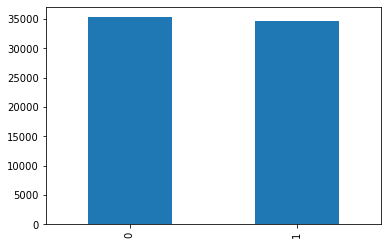

In [19]:
#на графике видим, что распределение целевой переменной по классам равномерное
clean_data['churn'].value_counts().plot(kind='bar', orientation='vertical');

In [21]:
#outlier detection by interquantile
def outlier_detect_IQR(data,col,threshold=5):    
    IQR = data[col].quantile(0.95) - data[col].quantile(0.05)
    Lower_fence = data[col].quantile(0.05) - (IQR * threshold)
    Upper_fence = data[col].quantile(0.95) + (IQR * threshold)
    para = (Upper_fence, Lower_fence)
    tmp = pd.concat([data[col]>Upper_fence,data[col]<Lower_fence],axis=1)
    outlier_index = tmp.any(axis=1)
    print('Количество выбросов в данных:',outlier_index.value_counts()[1])
    print('Доля выбросов:',outlier_index.value_counts()[1]/len(outlier_index))
    return outlier_index[outlier_index==True].index, para

IQR_out_ind, IQR_out_para  = outlier_detect_IQR(raw_data, num_cols)

Количество выбросов в данных: 6311
Доля выбросов: 0.09015843083472622


In [22]:
mean_out_ind, mean_out_para = outlier_detect_mean_std(raw_data, col=num_cols);

Количество выбросов в данных: 22343
Доля выбросов: 0.31919027414677353


Была попытка дропнуть выбросы, но к успеху не привела и качество модели не улучшило. Часть инфа осталось, часть результатов утеряна. Оставила тут просто как подсчет.

In [23]:
#создала трансформер датасета, который станартизирует числовые фичи, кодирует с помощью OHE категориальные и добавляет РСА

from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
np.set_printoptions(threshold=np.inf)
transformer = ColumnTransformer(transformers=[('cat', OneHotEncoder(), cat_cols),
                                 ('num', StandardScaler(), num_cols),
                                 ('pca', PCA(n_components=0.8), num_cols)], remainder='passthrough')

In [24]:
import time
def randomized_cv(model, param_grid, x_train, y_train):
    grid_search = RandomizedSearchCV(model, param_grid, cv=5, scoring='accuracy')
    t_start = time.time()
    grid_search.fit(x_train, y_train)
    t_end = time.time()
    print('model {} best accuracy score is {}'.format(model.__class__.__name__, grid_search.best_score_))
    print('time for training is {} seconds'.format(t_end - t_start))
    print(grid_search.best_score_)
    return grid_search.best_estimator_

In [21]:
# clean_data.drop(index=IQR_out_ind, inplace=True)

In [25]:
X_train = clean_data.drop(['churn'], axis=1)
y_train = clean_data['churn']

In [28]:
test_path = r'telcom_churn_test.csv'
test_data = pd.read_csv(path_to_files+'\\'+test_path).dropna()
X_test = test_data.drop(['churn']+list(list_to_drop), axis=1)
y_test = test_data['churn']

In [31]:
%matplotlib inline
#на нестандартизированных некодированных данных. Параметры модели из лучших данных по итогу GridSearh
from catboost import CatBoostClassifier
clf = CatBoostClassifier(eval_metric='AUC',
                         custom_metric='AUC:hints=skip_train~false',
                         n_estimators = 700,
                         l2_leaf_reg = 0.75, 
                         learning_rate = 0.1, 
                         depth = 6,
                         task_type='GPU')
clf.fit(X_train, y_train, cat_features=list(cat_cols), plot=True, logging_level='Silent');

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Default metric period is 5 because AUC is/are not implemented for GPU


In [32]:
roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])

0.69636947171833

In [33]:
X_train_transformed = transformer.fit_transform(X_train)

In [29]:
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.pipeline import Pipeline

clf1 = LogisticRegression()
clf2 = RandomForestClassifier()
clf3 = GaussianNB()

eclf = VotingClassifier(estimators=[('lr', clf1),
                                    ('rf', clf2),
                                    ('gnb', clf3)],
                        voting='soft')

params = {'lr__C': [1.0, 100.0],
          'rf__n_estimators': [100, 500],}

grid = GridSearchCV(estimator=eclf, param_grid=params, cv=5)
grid = grid.fit(X_train_transformed, y_train)
grid.best_estimator_


VotingClassifier(estimators=[('lr', LogisticRegression(C=100.0)),
                             ('rf', RandomForestClassifier()),
                             ('gnb', GaussianNB())],
                 voting='soft')

In [33]:
print(f'score {roc_auc_score(y_test, grid.predict_proba(transformer.transform(X_test))[:, 1])}')

score 0.644992759416236


In [34]:
from numpy import loadtxt
from xgboost import XGBClassifier
from xgboost import plot_tree
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline

model = Pipeline(steps=[("transformer", transformer), 
                        ("classifier", XGBClassifier(max_depth=5, learning_rate=0.01, n_estimators=400, n_jobs = -1))])
model.fit(X_train, y_train)

roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])

0.6875432891221007

In [35]:
xgb = XGBClassifier(max_depth=5, n_estimators=400, n_jobs = -1)
xgb.fit(X_train_transformed, y_train)
roc_auc_score(y_test, xgb.predict_proba(transformer.transform(X_test))[:, 1])

0.6727402174233535

In [35]:
KNN = KNeighborsClassifier()
KNN.fit(X_train_transformed, y_train)
print(f'KNN score {roc_auc_score(y_test, KNN.predict_proba(transformer.transform(X_test))[:, 1])}')

tree = DecisionTreeClassifier(max_depth=5)
tree.fit(X_train_transformed, y_train)
print(f'DecisionTreeClassifier score {roc_auc_score(y_test, tree.predict_proba(transformer.transform(X_test))[:, 1])}')

Ada = AdaBoostClassifier(n_estimators=500, learning_rate=0.1)
Ada.fit(X_train_transformed, y_train)
print(f'AdaBoostClassifier score {roc_auc_score(y_test, Ada.predict_proba(transformer.transform(X_test))[:, 1])}')

grad_boost = GradientBoostingClassifier(n_estimators=500)
grad_boost.fit(X_train_transformed, y_train)
print(f'GradientBoostingClassifier score {roc_auc_score(y_test, grad_boost.predict_proba(transformer.transform(X_test))[:, 1])}')

rf = RandomForestClassifier(max_depth=5, n_estimators=500, n_jobs=-1)
rf.fit(X_train_transformed, y_train)
print(f'RandomForestClassifier score {roc_auc_score(y_test, rf.predict_proba(transformer.transform(X_test))[:, 1])}')

log_reg = LogisticRegression()
log_reg.fit(X_train_transformed, y_train)
print(f'LogisticRegression score {roc_auc_score(y_test, log_reg.predict_proba(transformer.transform(X_test))[:, 1])}')

KNN score 0.5152732367662546
DecisionTreeClassifier score 0.6489439262267128
AdaBoostClassifier score 0.6719409854871219
GradientBoostingClassifier score 0.6959924217263133
RandomForestClassifier score 0.6421984726624153
LogisticRegression score 0.5114101085559055


In [36]:
#Создала новый трансформер без ОНЕ, чтобы применить его для Катбуста и сохранить категориальные фичи.
transformer_ = ColumnTransformer([('num', StandardScaler(), num_cols),
                                ('pca', PCA(n_components=0.8), num_cols)], remainder='passthrough')
X_train_cat_transformed = transformer_.fit_transform(X_train)

In [37]:
X_train.shape

(69999, 89)

In [38]:
# глупый способ, но как есть. В процессе транформации теряются название колонок в датасете, 
# а в модель надо передать названия или индексы кат фичей. 
# Тут перебираем первую строку трансформированных данных и получаем индексы кат фичей.
ind = 0
list_ind = []
for i in X_train_cat_transformed[0]:
  if type(i) == str:
    list_ind.append(ind)
  ind += 1

list_ind

[75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]

In [39]:
CB = CatBoostClassifier(cat_features=list_ind, task_type='GPU')
CB.fit(X_train_cat_transformed, y_train, silent=True)
print(f'CatBoostClassifier score {roc_auc_score(y_test, CB.predict_proba(transformer_.transform(X_test))[:, 1])}')

CatBoostClassifier score 0.6984890740342041


In [40]:
CB_grid = CatBoostClassifier(cat_features=list_ind)
                            #  , task_type='GPU')
params={'n_estimators': np.arange(100, 1000, 100),
        'l2_leaf_reg': np.linspace(0, 1, 5),
        'learning_rate': [0.01, 0.1],
        'depth': np.arange(2, 7, 2)}
CB_grid.randomized_search(params,
                     X_train_cat_transformed,
                     y_train,
                     cv=3,
                     n_iter=10)

Выходные данные были обрезаны до нескольких последних строк (5000).
341:	learn: 0.6571219	test: 0.6569472	best: 0.6569472 (341)	total: 33s	remaining: 44.2s
342:	learn: 0.6570802	test: 0.6569184	best: 0.6569184 (342)	total: 33.1s	remaining: 44.1s
343:	learn: 0.6570489	test: 0.6568945	best: 0.6568945 (343)	total: 33.2s	remaining: 44s
344:	learn: 0.6570226	test: 0.6568622	best: 0.6568622 (344)	total: 33.3s	remaining: 43.9s
345:	learn: 0.6569795	test: 0.6568285	best: 0.6568285 (345)	total: 33.4s	remaining: 43.8s
346:	learn: 0.6569380	test: 0.6567850	best: 0.6567850 (346)	total: 33.5s	remaining: 43.7s
347:	learn: 0.6568950	test: 0.6567456	best: 0.6567456 (347)	total: 33.6s	remaining: 43.7s
348:	learn: 0.6568715	test: 0.6567186	best: 0.6567186 (348)	total: 33.7s	remaining: 43.5s
349:	learn: 0.6568416	test: 0.6566913	best: 0.6566913 (349)	total: 33.8s	remaining: 43.4s
350:	learn: 0.6568047	test: 0.6566636	best: 0.6566636 (350)	total: 33.9s	remaining: 43.4s
351:	learn: 0.6567691	test: 0.656630

{'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               45,
               46,
               47,
               48,
               49,
             

 'params':\
  {'depth': 6,\
  'iterations': 700,\
  'l2_leaf_reg': 0.75,\
  'learning_rate': 0.1}}

In [40]:
CB_grid = CatBoostClassifier(cat_features=list_ind,
                             n_estimators = 700,
                             l2_leaf_reg = 0.75, 
                             learning_rate = 0.1, 
                             depth = 6,
                             task_type='GPU')
CB_grid.fit(X_train_cat_transformed, y_train, silent=True)
print(f'CatBoostClassifier score {roc_auc_score(y_test, CB_grid.predict_proba(transformer_.transform(X_test))[:, 1])}')

CatBoostClassifier score 0.6973558378354021


In [41]:
best_model = CB.save_model('best_model')

In [46]:
#open file with validation data

val_path = r'telcom_customer_churn.csv'  #сюда вставить путь до валидационного файла 
val_data = pd.read_csv(val_path)
val_data.dropna(inplace=True)
X_val = val_data.drop(['churn']+list(list_to_drop), axis=1)
y_val = val_data['churn']

# Load from file 
#  with open(pkl_filename, 'rb') as file: 
#  pickle_model = pickle.load(file) 
from_file = CatBoostClassifier()
model = from_file.load_model('best_model')
 # Calculate the accuracy score and predict target values 
score = roc_auc_score(y_val, model.predict_proba(transformer_.transform(X_val))[:, 1]) 
print("Test score: {0:.2f} %".format(100 * score))

Test score: 73.75 %
